# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle that contains information on 3 million used cars.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### **Answer: Reframing the Problem as a Data problem**

**TASK**: 
- Use the vehicle data to PREDICT the features that affect the price column of used vehicles. 
- Convert the features into encoded columns. 
- Build both a Linear and Polynomial Regression of degree 3 with a Sequential Feature Selector model 
- Compare the results of the two models. 
- Use GridSearchCV to select the best score for both models?

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

### Answer: Steps to understand the data
- Obtain the Dataset
- Drop unwanted columns (VIN, in this case)
- Describe the Dataset
- Fill Empty Cells
- Replace zero values on the price column with the mean of the column
- Encode the columns with category type
- Plot a histogram of the encoded data
- Obtain the Correlation Coefficients to determine column importance
- Convet the encoded columns to float type
- Scale the Data
- Perform Principal Component Analysis on the Data

In [185]:
import statsmodels.tsa.filters.filtertools as ft
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.filters.filtertools import convolution_filter
from sklearn.feature_selection import SequentialFeatureSelector
from statsmodels.tsa.seasonal import _extrapolate_trend
import pandas.testing as tm
import statsmodels.tsa.arima_process as arima_process
import statsmodels.graphics.tsaplots as tsaplots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder
from sklearn.linear_model import Ridge
from scipy import stats
from scipy.linalg import svd

import warnings
warnings.filterwarnings('ignore')

In [186]:
veh = pd.read_csv('data/vehicles.csv')

In [187]:
veh.head(3)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl


### 1. Information about the data

In [188]:
veh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [189]:
veh.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'odometer'}>]], dtype=object)

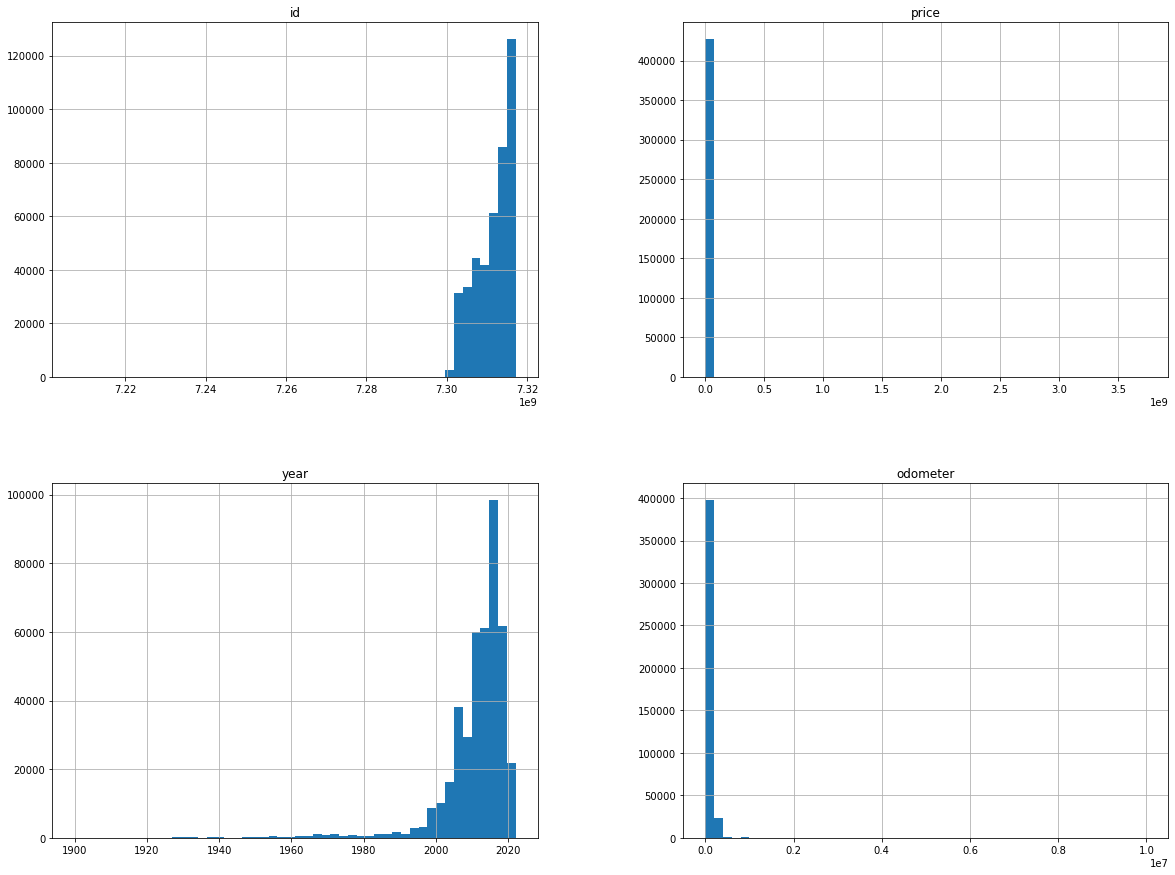

In [190]:
veh.hist(bins=50, figsize=(20,15))

<AxesSubplot:xlabel='price', ylabel='odometer'>

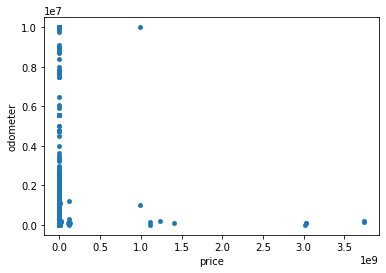

In [191]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
veh.plot(ax=ax, x='price', y='odometer', kind='scatter', style='k-', linewidth=0.5)

<AxesSubplot:xlabel='price', ylabel='year'>

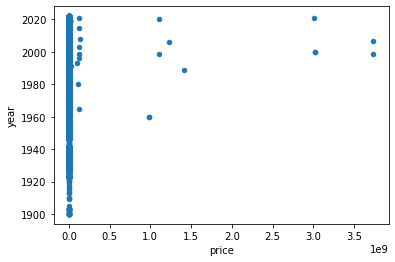

In [192]:
veh.plot(kind='scatter', x='price', y='year')

### 2. Drop Unwanted Columns

In [193]:
veh = veh.drop(columns=["VIN"],axis=1)

In [194]:
# REMOVE OUTLIERS
Q1 = np.percentile(veh['price'], 25,
                   interpolation='midpoint')

Q3 = np.percentile(veh['price'], 75,
                   interpolation='midpoint')
IQR = Q3 - Q1
IQR

upper = np.where(veh['price'] >= (Q3 + 1.5 * IQR))
lower = np.where(veh['price'] <= (Q1 - 1.5 * IQR))

veh.drop(upper[0], inplace=True)
veh.drop(lower[0], inplace=True)
veh

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,fwd,NaN,sedan,NaN,wy
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,fwd,NaN,sedan,red,wy
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,NaN,NaN,hatchback,white,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,fwd,NaN,sedan,silver,wy


### 3. Fill Empty Cells

In [195]:
veh["size"].fillna( method ='ffill', inplace = True)
veh["size"].fillna( method ='bfill', inplace = True)

veh["manufacturer"].fillna( method ='ffill', inplace = True)
veh["manufacturer"].fillna( method ='bfill', inplace = True)

veh["model"].fillna( method ='ffill', inplace = True)
veh["model"].fillna( method ='bfill', inplace = True)

veh["year"].fillna( method ='ffill', inplace = True)
veh["year"].fillna( method ='bfill', inplace = True)

veh["cylinders"].fillna( method ='ffill', inplace = True)
veh["cylinders"].fillna( method ='bfill', inplace = True)

veh["fuel"].fillna( method ='ffill', inplace = True)
veh["fuel"].fillna( method ='bfill', inplace = True)

veh["odometer"].fillna( method ='ffill', inplace = True)
veh["odometer"].fillna( method ='bfill', inplace = True)

veh["title_status"].fillna( method ='ffill', inplace = True)
veh["title_status"].fillna( method ='bfill', inplace = True)

veh["transmission"].fillna( method ='ffill', inplace = True)
veh["transmission"].fillna( method ='bfill', inplace = True)

veh["drive"].fillna( method ='ffill', inplace = True)
veh["drive"].fillna( method ='bfill', inplace = True)

veh["type"].fillna( method ='ffill', inplace = True)
veh["type"].fillna( method ='bfill', inplace = True)

veh["paint_color"].fillna( method ='ffill', inplace = True)
veh["paint_color"].fillna( method ='bfill', inplace = True)

veh["condition"].fillna( method ='ffill', inplace = True)
veh["condition"].fillna( method ='bfill', inplace = True)
veh.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,7222695916,prescott,6000,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,rwd,full-size,pickup,white,az
1,7218891961,fayetteville,11900,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,rwd,full-size,pickup,white,ar
2,7221797935,florida keys,21000,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,rwd,full-size,pickup,white,fl
3,7222270760,worcester / central MA,1500,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,rwd,full-size,pickup,white,ma
4,7210384030,greensboro,4900,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,rwd,full-size,pickup,white,nc


In [196]:
veh.model.value_counts(dropna=False)

f-150                      8010
silverado 1500             5173
1500                       4221
camry                      3164
silverado                  3009
                           ... 
kicks s                       1
pickup 1500 4x4               1
q7 s line                     1
SUZUKI FORENZA                1
Paige Glenbrook Touring       1
Name: model, Length: 28842, dtype: int64

### 4. Replace Zeros on the price column with mean of the column

In [197]:
# REPLACE ZEROs WITH THE MEAN OF THE PRICE COLUMN
mean_price = int(pd.to_numeric(veh['price'].mean(skipna=True)))
veh['price']=veh.price.mask(veh.price == 0,mean_price)
veh.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,7222695916,prescott,6000,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,rwd,full-size,pickup,white,az
1,7218891961,fayetteville,11900,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,rwd,full-size,pickup,white,ar
2,7221797935,florida keys,21000,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,rwd,full-size,pickup,white,fl
3,7222270760,worcester / central MA,1500,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,rwd,full-size,pickup,white,ma
4,7210384030,greensboro,4900,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,rwd,full-size,pickup,white,nc


In [198]:
veh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418703 entries, 0 to 426879
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            418703 non-null  int64  
 1   region        418703 non-null  object 
 2   price         418703 non-null  int64  
 3   year          418703 non-null  float64
 4   manufacturer  418703 non-null  object 
 5   model         418703 non-null  object 
 6   condition     418703 non-null  object 
 7   cylinders     418703 non-null  object 
 8   fuel          418703 non-null  object 
 9   odometer      418703 non-null  float64
 10  title_status  418703 non-null  object 
 11  transmission  418703 non-null  object 
 12  drive         418703 non-null  object 
 13  size          418703 non-null  object 
 14  type          418703 non-null  object 
 15  paint_color   418703 non-null  object 
 16  state         418703 non-null  object 
dtypes: float64(2), int64(2), object(13)
memory usage

In [199]:
veh.describe()

,id,price,year,odometer
count,4.187030e+05,418703.000000,418703.000000,4.187030e+05
mean,7.311487e+09,17626.696398,2011.166665,9.910874e+04
std,4.474037e+06,12257.608376,9.370809,2.145711e+05
min,7.207408e+09,1.000000,1900.000000,0.000000e+00
25%,7.308147e+09,7700.000000,2008.000000,3.918050e+04
50%,7.312619e+09,16342.000000,2013.000000,8.712500e+04
75%,7.315253e+09,25590.000000,2017.000000,1.346365e+05
max,7.317101e+09,57341.000000,2022.000000,1.000000e+07


### 5. Create an encoded DataFrame and fill it with encoded columns

In [200]:
veh_enc = veh

In [201]:
veh_enc.head(3)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,7222695916,prescott,6000,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,rwd,full-size,pickup,white,az
1,7218891961,fayetteville,11900,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,rwd,full-size,pickup,white,ar
2,7221797935,florida keys,21000,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,rwd,full-size,pickup,white,fl


In [202]:
veh_enc["size"] = veh_enc["size"].astype('category')
veh_enc["size"] = veh_enc["size"].cat.codes

veh_enc["manufacturer"] = veh_enc["manufacturer"].astype('category')
veh_enc["manufacturer"] = veh_enc["manufacturer"].cat.codes

veh_enc["model"] = veh_enc["model"].astype('category')
veh_enc["model"] = veh_enc["model"].cat.codes

veh_enc["condition"] = veh_enc["condition"].astype('category')
veh_enc["condition"] = veh_enc["condition"].cat.codes

veh_enc["cylinders"] = veh_enc["cylinders"].astype('category')
veh_enc["cylinders"] = veh_enc["cylinders"].cat.codes

veh_enc["fuel"] = veh_enc["fuel"].astype('category')
veh_enc["fuel"] = veh_enc["fuel"].cat.codes

veh_enc["title_status"] = veh_enc["title_status"].astype('category')
veh_enc["title_status"] = veh_enc["title_status"].cat.codes

veh_enc["transmission"] = veh_enc["transmission"].astype('category')
veh_enc["transmission"] = veh_enc["transmission"].cat.codes

veh_enc["drive"] = veh_enc["drive"].astype('category')
veh_enc["drive"] = veh_enc["drive"].cat.codes

veh_enc["type"] = veh_enc["type"].astype('category')
veh_enc["type"] = veh_enc["type"].cat.codes

veh_enc["paint_color"] = veh_enc["paint_color"].astype('category')
veh_enc["paint_color"] = veh_enc["paint_color"].cat.codes

veh_enc["state"] = veh_enc["state"].astype('category')
veh_enc["state"] = veh_enc["state"].cat.codes

veh_enc["region"] = veh_enc["region"].astype('category')
veh_enc["region"] = veh_enc["region"].cat.codes
veh_enc

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,7222695916,277,6000,2014.0,14,23679,2,6,2,57923.0,0,2,2,1,8,10,3
1,7218891961,105,11900,2014.0,14,23679,2,6,2,57923.0,0,2,2,1,8,10,2
2,7221797935,111,21000,2014.0,14,23679,2,6,2,57923.0,0,2,2,1,8,10,9
3,7222270760,396,1500,2014.0,14,23679,2,6,2,57923.0,0,2,2,1,8,10,19
4,7210384030,131,4900,2014.0,14,23679,2,6,2,57923.0,0,2,2,1,8,10,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,7301591192,397,23590,2019.0,31,19177,2,5,2,32226.0,0,2,1,1,9,10,50
426876,7301591187,397,30590,2020.0,41,22979,2,5,2,12029.0,0,2,1,1,9,8,50
426877,7301591147,397,34990,2020.0,6,28525,2,5,0,4174.0,0,2,1,1,4,10,50
426878,7301591140,397,28990,2018.0,23,13117,2,5,2,30112.0,0,2,1,1,9,9,50


### 6. Plot a Histogram of the encoded data

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'region'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'year'}>],
       [<AxesSubplot:title={'center':'manufacturer'}>,
        <AxesSubplot:title={'center':'model'}>,
        <AxesSubplot:title={'center':'condition'}>,
        <AxesSubplot:title={'center':'cylinders'}>],
       [<AxesSubplot:title={'center':'fuel'}>,
        <AxesSubplot:title={'center':'odometer'}>,
        <AxesSubplot:title={'center':'title_status'}>,
        <AxesSubplot:title={'center':'transmission'}>],
       [<AxesSubplot:title={'center':'drive'}>,
        <AxesSubplot:title={'center':'size'}>,
        <AxesSubplot:title={'center':'type'}>,
        <AxesSubplot:title={'center':'paint_color'}>],
       [<AxesSubplot:title={'center':'state'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

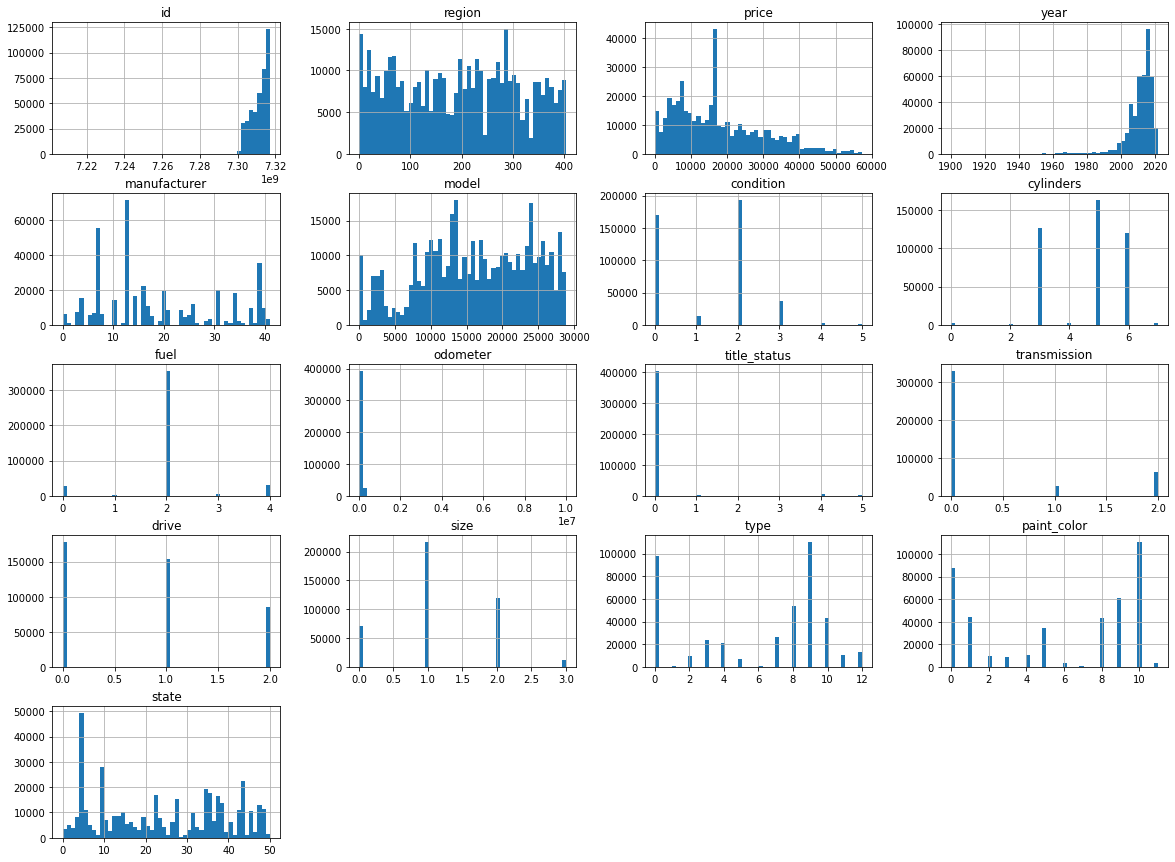

In [203]:
veh_enc.hist(bins=50, figsize=(20,15))

Text(0.5, 1.0, 'Actual vs Predicted')

<Figure size 720x432 with 0 Axes>

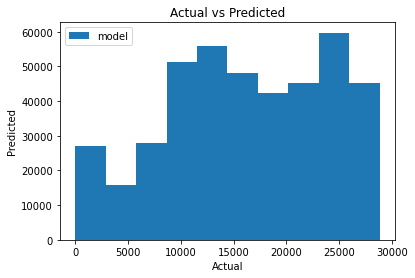

In [204]:
plt.figure(figsize=(10,6))
veh_enc.plot(kind='hist', x='price', y='model')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')

### 7. Correlations

In [205]:
veh_enc = veh_enc.set_index('id')
corr_matrix = veh_enc.corr()
corr_matrix

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
region,1.000000,-0.020763,-0.004157,0.001649,-0.000126,-0.019182,-0.005632,-0.004121,-0.001220,-0.007775,-0.015365,0.010804,-0.015130,0.003995,-0.002052,-0.038317
price,-0.020763,1.000000,0.355200,-0.041442,0.026248,0.107373,0.199962,-0.005508,-0.162614,-0.089235,0.307236,-0.068789,-0.001453,0.039414,0.017881,0.010079
year,-0.004157,0.355200,1.000000,0.027750,0.052774,0.051114,-0.070556,0.107189,-0.155130,-0.018969,0.135693,-0.114218,0.001756,0.013457,0.007214,0.010456
manufacturer,0.001649,-0.041442,0.027750,1.000000,-0.018386,-0.020073,-0.122711,-0.025099,-0.000722,0.014021,-0.000205,-0.068355,-0.000655,0.038011,0.006123,-0.012771
model,-0.000126,0.026248,0.052774,-0.018386,1.000000,0.001235,0.038252,0.073056,-0.007928,-0.010276,0.012444,-0.098435,0.002927,-0.089162,0.009343,0.003504
condition,-0.019182,0.107373,0.051114,-0.020073,0.001235,1.000000,0.068600,0.094041,-0.023420,0.000879,0.231510,0.062349,-0.002753,0.033196,-0.005268,0.029656
cylinders,-0.005632,0.199962,-0.070556,-0.122711,0.038252,0.068600,1.000000,-0.028989,0.009578,-0.046369,0.098820,-0.013986,-0.006446,0.032865,0.019090,0.028747
fuel,-0.004121,-0.005508,0.107189,-0.025099,0.073056,0.094041,-0.028989,1.000000,-0.073469,-0.013124,0.262942,0.062470,0.010062,-0.059668,-0.040134,-0.027363
odometer,-0.001220,-0.162614,-0.155130,-0.000722,-0.007928,-0.023420,0.009578,-0.073469,1.000000,0.008947,-0.102936,-0.012854,-0.001977,0.005508,0.007102,-0.001064
title_status,-0.007775,-0.089235,-0.018969,0.014021,-0.010276,0.000879,-0.046369,-0.013124,0.008947,1.000000,-0.053997,0.002641,-0.002503,-0.002931,-0.007670,0.003890


In [206]:
veh_enc.head(3)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
id,,,,,,,,,,,,,,,,
7222695916,277,6000,2014.0,14,23679,2,6,2,57923.0,0,2,2,1,8,10,3
7218891961,105,11900,2014.0,14,23679,2,6,2,57923.0,0,2,2,1,8,10,2
7221797935,111,21000,2014.0,14,23679,2,6,2,57923.0,0,2,2,1,8,10,9


In [207]:
corr_matrix['price'].sort_values(ascending=False)

price           1.000000
year            0.355200
transmission    0.307236
cylinders       0.199962
condition       0.107373
type            0.039414
model           0.026248
paint_color     0.017881
state           0.010079
size           -0.001453
fuel           -0.005508
region         -0.020763
manufacturer   -0.041442
drive          -0.068789
title_status   -0.089235
odometer       -0.162614
Name: price, dtype: float64

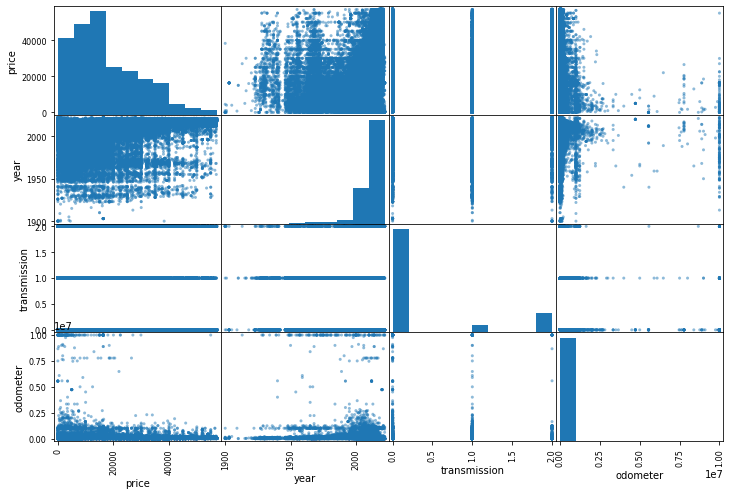

In [208]:
from pandas.plotting import scatter_matrix
attributes = ['price','year','transmission','odometer']
scatter_matrix(veh_enc[attributes], figsize=(12,8))
plt.show()

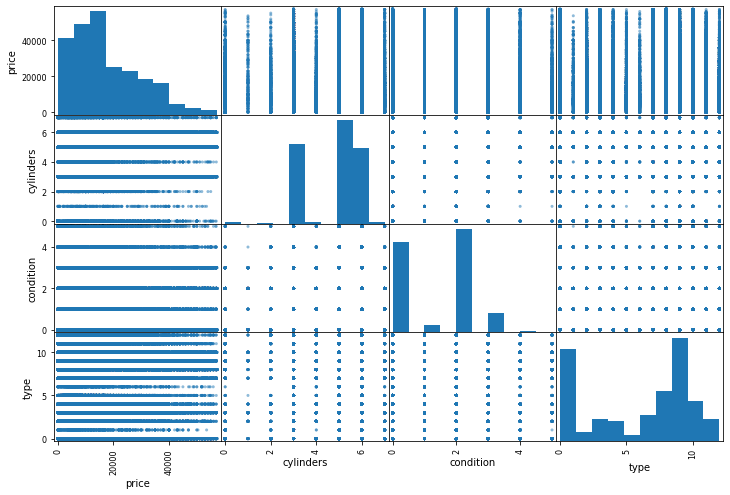

In [209]:
attributes2 = ['price','cylinders','condition','type']
scatter_matrix(veh_enc[attributes2], figsize=(12,8))
plt.show()

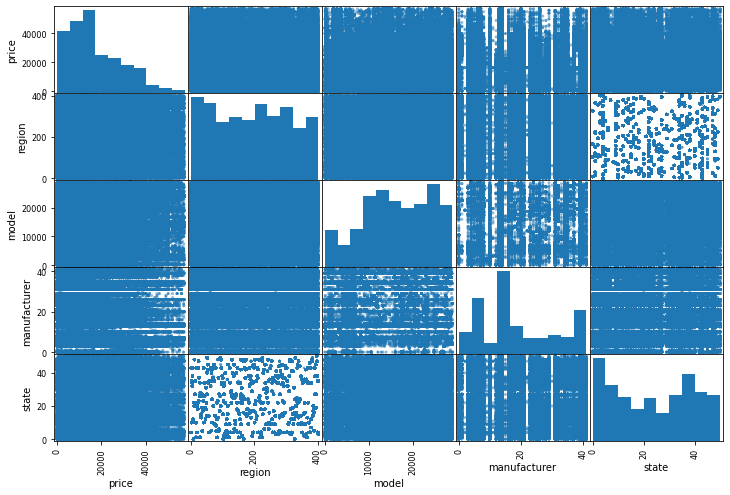

In [210]:
attributes3 = ['price','region','model','manufacturer','state']
scatter_matrix(veh_enc[attributes3], figsize=(12,8))
plt.show()

In [211]:
veh_enc.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
id,,,,,,,,,,,,,,,,
7222695916,277,6000,2014.0,14,23679,2,6,2,57923.0,0,2,2,1,8,10,3
7218891961,105,11900,2014.0,14,23679,2,6,2,57923.0,0,2,2,1,8,10,2
7221797935,111,21000,2014.0,14,23679,2,6,2,57923.0,0,2,2,1,8,10,9
7222270760,396,1500,2014.0,14,23679,2,6,2,57923.0,0,2,2,1,8,10,19
7210384030,131,4900,2014.0,14,23679,2,6,2,57923.0,0,2,2,1,8,10,27


In [212]:
veh_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418703 entries, 7222695916 to 7301591129
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        418703 non-null  int16  
 1   price         418703 non-null  int64  
 2   year          418703 non-null  float64
 3   manufacturer  418703 non-null  int8   
 4   model         418703 non-null  int16  
 5   condition     418703 non-null  int8   
 6   cylinders     418703 non-null  int8   
 7   fuel          418703 non-null  int8   
 8   odometer      418703 non-null  float64
 9   title_status  418703 non-null  int8   
 10  transmission  418703 non-null  int8   
 11  drive         418703 non-null  int8   
 12  size          418703 non-null  int8   
 13  type          418703 non-null  int8   
 14  paint_color   418703 non-null  int8   
 15  state         418703 non-null  int8   
dtypes: float64(2), int16(2), int64(1), int8(11)
memory usage: 18.8 MB


In [213]:
X = veh_enc
X = veh_enc.astype('float')
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418703 entries, 7222695916 to 7301591129
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        418703 non-null  float64
 1   price         418703 non-null  float64
 2   year          418703 non-null  float64
 3   manufacturer  418703 non-null  float64
 4   model         418703 non-null  float64
 5   condition     418703 non-null  float64
 6   cylinders     418703 non-null  float64
 7   fuel          418703 non-null  float64
 8   odometer      418703 non-null  float64
 9   title_status  418703 non-null  float64
 10  transmission  418703 non-null  float64
 11  drive         418703 non-null  float64
 12  size          418703 non-null  float64
 13  type          418703 non-null  float64
 14  paint_color   418703 non-null  float64
 15  state         418703 non-null  float64
dtypes: float64(16)
memory usage: 54.3 MB


### 8. Define the Modelling data

In [214]:
X = veh_enc.drop(['price'], axis=1)
y = veh_enc['price']

### 9. Scale the X data

In [215]:
X_scaled = StandardScaler().fit_transform(X)

### 10. Perform Principal Components Analysis on the X_scaled data for dimensionality reduction

In [216]:
pca = PCA(n_components=3)
pca_comp = pca.fit_transform(X_scaled)

X_pca = pd.DataFrame(data=pca_comp, columns=['pca1','pca2','pca3'])
X_pca.head(3)

,pca1,pca2,pca3
0,-2.221980,1.671566,0.208682
1,-2.270492,1.638156,0.322834
2,-2.267811,1.585743,0.425610


### 11. The defined Modelling data

In [217]:
X = X_pca
y = y
y

id
7222695916     6000
7218891961    11900
7221797935    21000
7222270760     1500
7210384030     4900
              ...  
7301591192    23590
7301591187    30590
7301591147    34990
7301591140    28990
7301591129    30590
Name: price, Length: 418703, dtype: int64

In [218]:
#np.log1p
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [219]:
X_train.head(3)

,pca1,pca2,pca3
303096,0.003344,0.417326,0.534911
329039,1.217113,-0.617920,-1.160668
362032,-0.062009,-1.362353,0.779537


In [220]:
X_test.head(1)

,pca1,pca2,pca3
32615,-0.034884,0.367346,0.031994


## Create the Models

### **1. Plain Linear Regression**

In [221]:
linreg = Pipeline([('linreg', LinearRegression())])
linreg.fit(X_train, y_train)

Pipeline(steps=[('linreg', LinearRegression())])

#### Predict the test results

In [222]:
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

y_train_mse = mean_squared_error(y_train, y_train_pred)
y_test_mse = mean_squared_error(y_test, y_test_pred)

In [223]:
print("\033[1m", "Train Predictions: ", '\033[0m', y_train_pred.mean())
print("\033[1m", "Test Predictions: ", '\033[0m', y_test_pred.mean())
print(" ")
print("\033[1m", "Train MSE: ", '\033[0m', np.log1p(y_train_mse))
print("\033[1m", "Test MSE: ", '\033[0m', np.log1p(y_test_mse))

 Train Predictions:   17614.27424494698
 Test Predictions:   17636.583268868308
 
 Train MSE:   18.7029382169981
 Test MSE:   18.699556887592177


In [224]:
train_pred_first = linreg.predict([[-0.005875,0.451736,0.494672]])
train_pred_first

array([17505.49108339])

In [225]:
test_pred_first = linreg.predict([[-0.064166,0.411703,0.110537]])
test_pred_first

array([17530.33658841])

### **2. Sequential Feature Selector with Linear Regression Model**

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [227]:
poly_features = PolynomialFeatures(degree = 3, include_bias=False)

In [228]:
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

In [229]:
columns = poly_features.get_feature_names()

In [230]:
train_df = pd.DataFrame(X_train_poly, columns=columns)
test_df = pd.DataFrame(X_test_poly, columns = columns)

In [231]:
selector = SequentialFeatureSelector(LinearRegression(), n_features_to_select=3)

In [232]:
pipe = Pipeline([('column_selector', selector),
                ('linreg', LinearRegression())])
pipe.fit(train_df, y_train)

Pipeline(steps=[('column_selector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=3)),
                ('linreg', LinearRegression())])

In [233]:
pipe_train_pred = pipe.predict(train_df)
pipe_test_pred = pipe.predict(test_df)

pipe_train_mse = mean_squared_error(y_train, pipe_train_pred)
pipe_test_mse = mean_squared_error(y_test, pipe_test_pred)

print("\033[1m", "Train Predictions: ", '\033[0m', pipe_train_pred.mean())
print("\033[1m", "Test Predictions: ", '\033[0m', pipe_test_pred.mean())
print(" ")
print("\033[1m", "Train MSE: ", '\033[0m', np.log1p(pipe_train_mse))
print("\033[1m", "Test MSE: ", '\033[0m', np.log1p(pipe_test_mse))

 Train Predictions:   17614.27424494698
 Test Predictions:   17638.416641930693
 
 Train MSE:   18.680502225033035
 Test MSE:   18.6778276282629


### **3. Ridge Regression Model**

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [235]:

ridge_pipe = Pipeline([('scaler', StandardScaler()), 
                      ('ridge', Ridge())])

In [236]:
ridge_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge())])

In [237]:
ridge_pipe_train_preds = ridge_pipe.predict(X_train)
ridge_pipe_test_preds = ridge_pipe.predict(X_test)
ridge_pipe_train_mse = mean_squared_error(y_train, ridge_pipe_train_preds)
ridge_pipe_test_mse = mean_squared_error(y_test, ridge_pipe_test_preds)

In [238]:

print("\033[1m", "Train Predictions: ", '\033[0m', ridge_pipe_train_preds.mean())
print("\033[1m", "Test Predictions: ", '\033[0m', ridge_pipe_test_preds.mean())
print(" ")
print("\033[1m", "Train MSE: ", '\033[0m', np.log1p(ridge_pipe_train_mse))
print("\033[1m", "Test MSE: ", '\033[0m', np.log1p(ridge_pipe_test_mse))

 Train Predictions:   17614.27424494698
 Test Predictions:   17636.583192738653
 
 Train MSE:   18.702938216999655
 Test MSE:   18.699556888246622


### **4. Lasso Regression Model**

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [240]:
lasso_pipe = Pipeline([('polyfeatures', PolynomialFeatures(degree = 3)),
                      ('scaler', StandardScaler()),
                     ('lasso', Lasso(random_state = 42))])

In [241]:
lasso_pipe.fit(X_train, y_train)
lasso_coefs = lasso_pipe.named_steps['lasso'].coef_

In [242]:
lasso_pipe_train_preds = lasso_pipe.predict(X_train)
lasso_pipe_test_preds = lasso_pipe.predict(X_test)

In [243]:
lasso_train_mse = mean_squared_error(y_train, lasso_pipe_train_preds)
lasso_test_mse = mean_squared_error(y_test, lasso_pipe_test_preds)

In [244]:
print("\033[1m", "Train Predictions: ", '\033[0m', lasso_pipe_train_preds.mean())
print("\033[1m", "Test Predictions: ", '\033[0m', lasso_pipe_test_preds.mean())
print(" ")
print("\033[1m", "Train MSE: ", '\033[0m', np.log1p(lasso_train_mse))
print("\033[1m", "Test MSE: ", '\033[0m', np.log1p(lasso_test_mse))

 Train Predictions:   17614.274244946984
 Test Predictions:   17650.448575362247
 
 Train MSE:   18.646723099786243
 Test MSE:   18.644297918585874


## **Model Evaluation**

#### **1. Plain Linear Regression Evaluation**

In [245]:
from sklearn.metrics import r2_score
r2score_linreg = r2_score(y_test, y_test_pred)

linreg_train_mse = mean_squared_error(y_train, y_train_pred)
linreg_test_mse = mean_squared_error(y_test, y_test_pred)

linreg_train_rmse = np.sqrt(linreg_train_mse)
linreg_test_rmse = np.sqrt(linreg_test_mse)

linreg_mean_train_pred = np.mean(y_train_pred)
linreg_mean_test_pred = np.mean(y_test_pred)


print("r2score:", r2score_linreg)
print(" ")
print("Train RMSE:", linreg_train_rmse)
print("Test RMSE:", linreg_test_rmse)
print(" ")
print("Mean Train Prediction:", linreg_mean_train_pred)
print("Mean Test Prediction:", linreg_mean_test_pred)

r2score: 0.11902726527158036
 
Train RMSE: 11515.728835901236
Test RMSE: 11496.27604818692
 
Mean Train Prediction: 17614.27424494698
Mean Test Prediction: 17636.583268868308


#### **>>Plot the results <<**

In [246]:
pred_y_linreg = pd.DataFrame({'Actual Value':y_test,'Predicted value':y_test_pred, 'Difference':y_test-y_test_pred})
pred_y_linreg[:4]

,Actual Value,Predicted value,Difference
id,,,
7316548741,4999,17432.596936,-12433.596936
7311144829,37614,16551.548753,21062.451247
7308183160,16342,20609.902479,-4267.902479
7306608008,14950,16859.178933,-1909.178933


Text(0.5, 1.0, 'Actual vs Predicted')

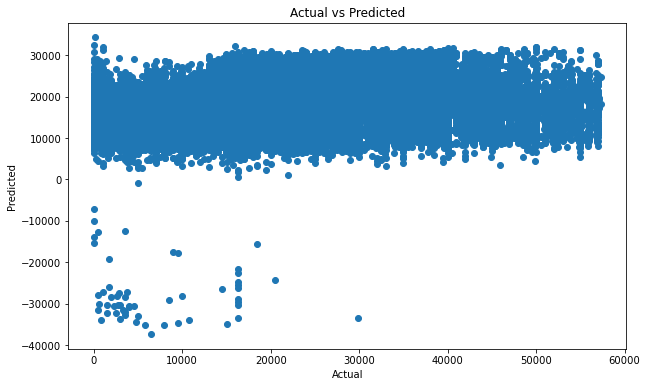

In [247]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_test_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')

In [248]:
linreg.get_params()

{'memory': None,
 'steps': [('linreg', LinearRegression())],
 'verbose': False,
 'linreg': LinearRegression(),
 'linreg__copy_X': True,
 'linreg__fit_intercept': True,
 'linreg__n_jobs': None,
 'linreg__normalize': False,
 'linreg__positive': False}

In [249]:
param_grid = {'linreg__fit_intercept':[True,False],
              'linreg__copy_X': [True, False], 
              'linreg__n_jobs': [None]}

In [250]:
grid = GridSearchCV(linreg, param_grid, cv=None)
grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('linreg', LinearRegression())]),
             param_grid={'linreg__copy_X': [True, False],
                         'linreg__fit_intercept': [True, False],
                         'linreg__n_jobs': [None]})

In [251]:
grid.cv_results_

{'mean_fit_time': array([0.10337639, 0.09371209, 0.09911513, 0.09455647]),
 'std_fit_time': array([0.00683281, 0.00790956, 0.01138418, 0.01485657]),
 'mean_score_time': array([0.01196747, 0.00797968, 0.01101618, 0.00958657]),
 'std_score_time': array([0.00267699, 0.0015488 , 0.00246948, 0.00174932]),
 'param_linreg__copy_X': masked_array(data=[True, True, False, False],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_linreg__fit_intercept': masked_array(data=[True, False, True, False],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_linreg__n_jobs': masked_array(data=[None, None, None, None],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'linreg__copy_X': True,
   'linreg__fit_intercept': True,
   'linreg__n_jobs': None},
  {'linreg__copy_X': True,
   'linreg__fit_intercept': False,
   'linreg__n_jo

In [252]:
grid.best_score_

0.11792011689975565

#### **2. Sequential Feature Selection with Linear Regression Evaluation**

In [253]:
r2score_pipe = r2_score(y_test, pipe_test_pred)
pipe_train_mse = mean_squared_error(y_train, pipe_train_pred)
pipe_train_rmse = np.sqrt(pipe_train_mse)
pipe_mean_train_pred = np.mean(pipe_train_pred)

pipe_test_mse = mean_squared_error(y_test, pipe_test_pred)
pipe_test_rmse = np.sqrt(pipe_test_mse)
pipe_mean_test_pred = np.mean(pipe_test_pred)

print("r2score:", r2score_pipe)
print(" ")
print("Train RMSE:", pipe_train_rmse)
print("Test RMSE:", pipe_test_rmse)

print(" ")
print("Mean Train Prediction:", pipe_mean_train_pred)
print("Mean Test Prediction:", pipe_mean_test_pred)

r2score: 0.1379636683451848
 
Train RMSE: 11387.26732264136
Test RMSE: 11372.049326091996
 
Mean Train Prediction: 17614.27424494698
Mean Test Prediction: 17638.416641930693


#### **>>Predicted values<<**

In [254]:
pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted value':pipe_test_pred, 'Difference':y_test-pipe_test_pred})
pred_y_df[:4]

,Actual Value,Predicted value,Difference
id,,,
7316548741,4999,16622.230791,-11623.230791
7311144829,37614,16144.261465,21469.738535
7308183160,16342,20037.674561,-3695.674561
7306608008,14950,16839.642166,-1889.642166


Text(0.5, 1.0, 'Actual vs Predicted')

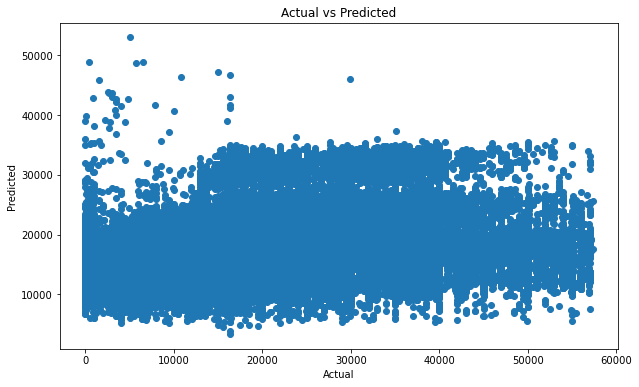

In [255]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, pipe_test_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')

In [256]:
pipe.get_params()

{'memory': None,
 'steps': [('column_selector',
   SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=3)),
  ('linreg', LinearRegression())],
 'verbose': False,
 'column_selector': SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=3),
 'linreg': LinearRegression(),
 'column_selector__cv': 5,
 'column_selector__direction': 'forward',
 'column_selector__estimator__copy_X': True,
 'column_selector__estimator__fit_intercept': True,
 'column_selector__estimator__n_jobs': None,
 'column_selector__estimator__normalize': False,
 'column_selector__estimator__positive': False,
 'column_selector__estimator': LinearRegression(),
 'column_selector__n_features_to_select': 3,
 'column_selector__n_jobs': None,
 'column_selector__scoring': None,
 'linreg__copy_X': True,
 'linreg__fit_intercept': True,
 'linreg__n_jobs': None,
 'linreg__normalize': False,
 'linreg__positive': False}

In [257]:
param_grid = {'column_selector__estimator__fit_intercept':[True,False],
              'column_selector__estimator__copy_X': [True, False], 
              'column_selector__n_features_to_select': [None]}

In [258]:
grid_pipe = GridSearchCV(pipe, param_grid, cv=None)
grid_pipe.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('column_selector',
                                        SequentialFeatureSelector(estimator=LinearRegression(),
                                                                  n_features_to_select=3)),
                                       ('linreg', LinearRegression())]),
             param_grid={'column_selector__estimator__copy_X': [True, False],
                         'column_selector__estimator__fit_intercept': [True,
                                                                       False],
                         'column_selector__n_features_to_select': [None]})

In [259]:
grid_pipe.cv_results_

{'mean_fit_time': array([0.76038318, 0.67273045, 0.79039445, 0.66937737]),
 'std_fit_time': array([0.0581197 , 0.03884362, 0.02728165, 0.0170312 ]),
 'mean_score_time': array([0.01077728, 0.01078615, 0.01175923, 0.01257725]),
 'std_score_time': array([0.00317421, 0.00192326, 0.00192262, 0.00150175]),
 'param_column_selector__estimator__copy_X': masked_array(data=[True, True, False, False],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_column_selector__estimator__fit_intercept': masked_array(data=[True, False, True, False],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_column_selector__n_features_to_select': masked_array(data=[None, None, None, None],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'column_selector__estimator__copy_X': True,
   'column_selector__estimator__fit_intercept': True,
   

In [260]:
grid_pipe.best_score_

0.10934274815181588

#### **3. Ridge Regression Evaluation**

In [261]:
r2score_ridge = r2_score(y_test, ridge_pipe_test_preds)
ridge_train_mse = mean_squared_error(y_train, ridge_pipe_train_preds)
ridge_train_rmse = np.sqrt(ridge_train_mse)
ridge_mean_train_pred = np.mean(ridge_pipe_train_preds)

ridge_test_mse = mean_squared_error(y_test, ridge_pipe_test_preds)
ridge_test_rmse = np.sqrt(ridge_test_mse)
ridge_mean_test_pred = np.mean(ridge_pipe_test_preds)

print("r2score:", r2score_ridge)
print(" ")
print("Train RMSE:", ridge_train_rmse)
print("Test RMSE:", ridge_test_rmse)

print(" ")
print("Mean Train Prediction:", ridge_mean_train_pred)
print("Mean Test Prediction:", ridge_mean_test_pred)

r2score: 0.11902726469503067
 
Train RMSE: 11515.728835910206
Test RMSE: 11496.276051948771
 
Mean Train Prediction: 17614.27424494698
Mean Test Prediction: 17636.583192738653


In [263]:
ridge_pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted value':ridge_pipe_test_preds, 'Difference':y_test-ridge_pipe_test_preds})
ridge_pred_y_df[:4]

,Actual Value,Predicted value,Difference
id,,,
7316548741,4999,17432.597559,-12433.597559
7311144829,37614,16551.552373,21062.447627
7308183160,16342,20609.892237,-4267.892237
7306608008,14950,16859.181499,-1909.181499


Text(0.5, 1.0, 'Actual vs Predicted')

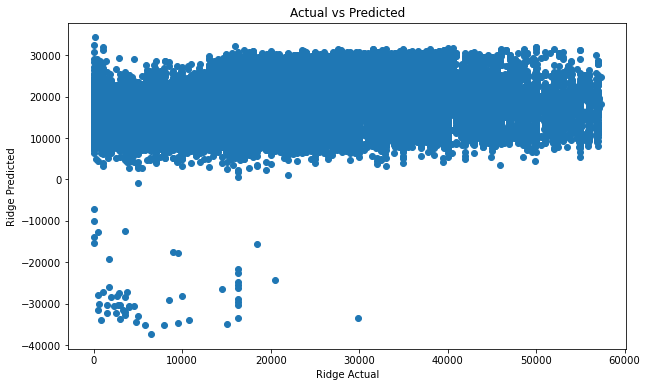

In [265]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, ridge_pipe_test_preds)
plt.xlabel('Ridge Actual')
plt.ylabel('Ridge Predicted')
plt.title('Actual vs Predicted')

In [267]:
ridge_param_dict = {'ridge__alpha': np.logspace(0, 10, 50)}

In [268]:
ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict)
ridge_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([1.00000000e+00, 1.59985872e+00, 2.55954792e+00, 4.09491506e+00,
       6.55128557e+00, 1.04811313e+01, 1.67683294e+01, 2.68269580e+01,
       4.29193426e+01, 6.86648845e+01, 1.09854114e+02, 1.75751062e+02,
       2.81176870e+02, 4.49843267e+02, 7.19685673e+02, 1.15...
       7.90604321e+04, 1.26485522e+05, 2.02358965e+05, 3.23745754e+05,
       5.17947468e+05, 8.28642773e+05, 1.32571137e+06, 2.12095089e+06,
       3.39322177e+06, 5.42867544e+06, 8.68511374e+06, 1.38949549e+07,
       2.22299648e+07, 3.55648031e+07, 5.68986603e+07, 9.10298178e+07,
       1.45634848e+08, 2.32995181e+08, 3.72759372e+08, 5.96362332e+08,
       9.54095476e+08, 1.52641797e+09, 2.44205309e+09, 3.90693994e+09,
       6.25055193e+09, 1.00000000e+10])})

In [269]:
ridge_grid.cv_results_

{'mean_fit_time': array([0.14131103, 0.14780455, 0.15548434, 0.1288271 , 0.14779439,
        0.13663073, 0.14129043, 0.13982244, 0.1309546 , 0.13512568,
        0.14417839, 0.14284263, 0.14510875, 0.14649715, 0.1322279 ,
        0.13267212, 0.15888901, 0.15337877, 0.14542327, 0.14876118,
        0.14440889, 0.13804855, 0.15061598, 0.13463826, 0.13356237,
        0.14416399, 0.13575625, 0.13653531, 0.12346463, 0.13542967,
        0.14324183, 0.15697994, 0.1395946 , 0.12249703, 0.13126979,
        0.14641352, 0.14740772, 0.15678396, 0.15255914, 0.13473606,
        0.14714522, 0.15577741, 0.1396173 , 0.13580947, 0.13051033,
        0.13822303, 0.12663879, 0.13419933, 0.14858675, 0.15666413]),
 'std_fit_time': array([0.01053712, 0.00775501, 0.00986809, 0.00864048, 0.01498861,
        0.00994774, 0.00787707, 0.01968377, 0.0125332 , 0.00836546,
        0.01757674, 0.00721221, 0.00352557, 0.00779985, 0.0097922 ,
        0.00854928, 0.00537893, 0.00644094, 0.00686585, 0.01386302,
        0.011

In [270]:
ridge_grid.best_score_

0.11792011971633173

#### **4. Lasso Regression Evaluation**

In [271]:
r2score_lasso = r2_score(y_test, lasso_pipe_test_preds)
lasso_train_mse = mean_squared_error(y_train, lasso_pipe_train_preds)
lasso_train_rmse = np.sqrt(lasso_train_mse)
lasso_mean_train_pred = np.mean(lasso_pipe_train_preds)

lasso_test_mse = mean_squared_error(y_test, lasso_pipe_test_preds)
lasso_test_rmse = np.sqrt(lasso_test_mse)
lasso_mean_test_pred = np.mean(lasso_pipe_test_preds)

print("r2score:", r2score_lasso)
print(" ")
print("Train RMSE:", lasso_train_rmse)
print("Test RMSE:", lasso_test_rmse)

print(" ")
print("Mean Train Prediction:", lasso_mean_train_pred)
print("Mean Test Prediction:", lasso_mean_test_pred)

r2score: 0.16638829873542105
 
Train RMSE: 11196.556402060858
Test RMSE: 11182.987791152536
 
Mean Train Prediction: 17614.274244946984
Mean Test Prediction: 17650.448575362247


In [272]:
lasso_pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted value':lasso_pipe_test_preds, 'Difference':y_test-lasso_pipe_test_preds})
lasso_pred_y_df[:4]

,Actual Value,Predicted value,Difference
id,,,
7316548741,4999,15323.977938,-10324.977938
7311144829,37614,16086.470997,21527.529003
7308183160,16342,22494.238070,-6152.238070
7306608008,14950,17575.831722,-2625.831722


Text(0.5, 1.0, 'Actual vs Predicted')

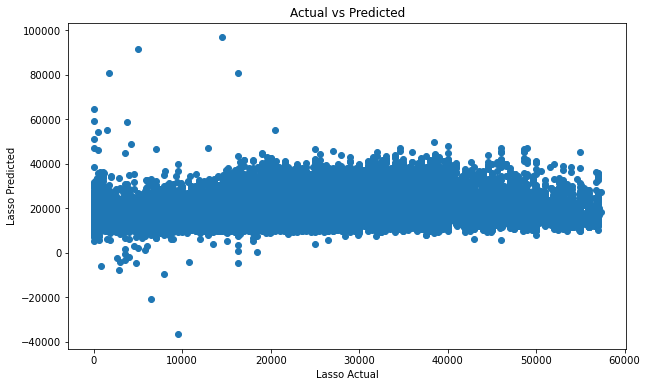

In [273]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, lasso_pipe_test_preds)
plt.xlabel('Lasso Actual')
plt.ylabel('Lasso Predicted')
plt.title('Actual vs Predicted')

In [274]:
lasso_pipe.get_params()

{'memory': None,
 'steps': [('polyfeatures', PolynomialFeatures(degree=3)),
  ('scaler', StandardScaler()),
  ('lasso', Lasso(random_state=42))],
 'verbose': False,
 'polyfeatures': PolynomialFeatures(degree=3),
 'scaler': StandardScaler(),
 'lasso': Lasso(random_state=42),
 'polyfeatures__degree': 3,
 'polyfeatures__include_bias': True,
 'polyfeatures__interaction_only': False,
 'polyfeatures__order': 'C',
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'lasso__alpha': 1.0,
 'lasso__copy_X': True,
 'lasso__fit_intercept': True,
 'lasso__max_iter': 1000,
 'lasso__normalize': False,
 'lasso__positive': False,
 'lasso__precompute': False,
 'lasso__random_state': 42,
 'lasso__selection': 'cyclic',
 'lasso__tol': 0.0001,
 'lasso__warm_start': False}

In [275]:
lasso_param_grid = {'lasso__fit_intercept':[True,False],
              'lasso__copy_X': [True, False], 
             }

In [276]:
lasso_grid = GridSearchCV(lasso_pipe, param_grid=lasso_param_grid)
lasso_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('polyfeatures',
                                        PolynomialFeatures(degree=3)),
                                       ('scaler', StandardScaler()),
                                       ('lasso', Lasso(random_state=42))]),
             param_grid={'lasso__copy_X': [True, False],
                         'lasso__fit_intercept': [True, False]})

In [277]:
lasso_grid.cv_results_

{'mean_fit_time': array([10.35103312, 10.19276886, 10.26373048, 10.38138633]),
 'std_fit_time': array([0.21514215, 0.2355935 , 0.31019558, 0.44626916]),
 'mean_score_time': array([0.10214324, 0.0953866 , 0.09334989, 0.09510121]),
 'std_score_time': array([0.0127035 , 0.01406192, 0.01033729, 0.00850765]),
 'param_lasso__copy_X': masked_array(data=[True, True, False, False],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_lasso__fit_intercept': masked_array(data=[True, False, True, False],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'lasso__copy_X': True, 'lasso__fit_intercept': True},
  {'lasso__copy_X': True, 'lasso__fit_intercept': False},
  {'lasso__copy_X': False, 'lasso__fit_intercept': True},
  {'lasso__copy_X': False, 'lasso__fit_intercept': False}],
 'split0_test_score': array([ 0.16621053, -1.90805054,  0.16621053, -1.90805054]),
 'split1_test_score

In [278]:
lasso_grid.best_score_

0.16577943624892363

### **Summary**

**1. Linear Regression**

In [279]:
print("r2score:", r2score_linreg)
print("Train RMSE:", linreg_train_rmse)
print("Test RMSE:", linreg_test_rmse)
print("Mean Train Prediction:", linreg_mean_train_pred)
print("Mean Test Prediction:", linreg_mean_test_pred)
print("Best score: ", grid.best_score_)

r2score: 0.11902726527158036
Train RMSE: 11515.728835901236
Test RMSE: 11496.27604818692
Mean Train Prediction: 17614.27424494698
Mean Test Prediction: 17636.583268868308
Best score:  0.11792011689975565


**2. Sequential Feature Selector with Linear Regression**

In [280]:
print("r2score:", r2score_pipe)
print("Train RMSE:", pipe_train_rmse)
print("Test RMSE:", pipe_test_rmse)
print("Mean Train Prediction:", pipe_mean_train_pred)
print("Mean Test Prediction:", pipe_mean_test_pred)
print("Best score: ", grid_pipe.best_score_)

r2score: 0.1379636683451848
Train RMSE: 11387.26732264136
Test RMSE: 11372.049326091996
Mean Train Prediction: 17614.27424494698
Mean Test Prediction: 17638.416641930693
Best score:  0.10934274815181588


**3. Ridge Regression Regression**

In [281]:
print("r2score:", r2score_ridge)
print("Train RMSE:", ridge_train_rmse)
print("Test RMSE:", ridge_test_rmse)
print("Mean Train Prediction:", ridge_mean_train_pred)
print("Mean Test Prediction:", ridge_mean_test_pred)
print("Best score: ", ridge_grid.best_score_)

r2score: 0.11902726469503067
Train RMSE: 11515.728835910206
Test RMSE: 11496.276051948771
Mean Train Prediction: 17614.27424494698
Mean Test Prediction: 17636.583192738653
Best score:  0.11792011971633173


**4. Lasso Regression**

In [282]:
print("r2score:", r2score_lasso)
print("Train RMSE:", lasso_train_rmse)
print("Test RMSE:", lasso_test_rmse)
print("Mean Train Prediction:", lasso_mean_train_pred)
print("Mean Test Prediction:", lasso_mean_test_pred)
print("Best score: ", lasso_grid.best_score_)

r2score: 0.16638829873542105
Train RMSE: 11196.556402060858
Test RMSE: 11182.987791152536
Mean Train Prediction: 17614.274244946984
Mean Test Prediction: 17650.448575362247
Best score:  0.16577943624892363


In [283]:
edata = {
            "Regressions": ['Linear Regression','Polynomial Regression','Ridge Regression','Lasso Regression'], 
            "r2score": [r2score_linreg,r2score_pipe, r2score_ridge, r2score_lasso], 
            "Train RMSE": [linreg_train_rmse,pipe_train_rmse, ridge_train_rmse, lasso_train_rmse], 
            "Test RMSE": [linreg_test_rmse,pipe_test_rmse, ridge_test_rmse, lasso_test_rmse], 
            "Mean Train Preds": [linreg_mean_train_pred,pipe_mean_train_pred, ridge_mean_train_pred, lasso_mean_train_pred], 
            "Mean Test Preds": [linreg_mean_test_pred,pipe_mean_test_pred, ridge_mean_test_pred, lasso_mean_test_pred], 
            "Best Score": [grid.best_score_,grid_pipe.best_score_, ridge_grid.best_score_, lasso_grid.best_score_]
        }

evals = pd.DataFrame(edata)
evals

,Regressions,r2score,Train RMSE,Test RMSE,Mean Train Preds,Mean Test Preds,Best Score
0,Linear Regression,0.119027,11515.728836,11496.276048,17614.274245,17636.583269,0.117920
1,Polynomial Regression,0.137964,11387.267323,11372.049326,17614.274245,17638.416642,0.109343
2,Ridge Regression,0.119027,11515.728836,11496.276052,17614.274245,17636.583193,0.117920
3,Lasso Regression,0.166388,11196.556402,11182.987791,17614.274245,17650.448575,0.165779


### **Model Selection**
- The **Lasso Regression Model** was selected because of the following features
    - r2score is highest
    - Test RMSE is smallest
    - Best Score is highest

## Deployment
Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

### Answer: Report
**A summary of Machine Learning analytic report**
- The findings of the analysis of used car data reveals that
    - Most vehicles sold starts in the range of \$17,600 to \\$18,000
    - Most cars sold are capped at around \$40,000
    - Selling cars whose years are nearer to year 2020 would be more profitable
    - Cylinder, Condition, and Model features strongly determine price of a vehicle.
    - The Higher the values of the four features, the higher the price of the vehicle
    - Odometer: The smaller the odometer readings, the higher the price of a vehicle

**Recommendations**
- To maintain profitability, it is advisable to maintain inventory of cars within the range of \$17,500 since they are very much on demand
- Maintaining an inventory of cars from \$40,000 and above is not profitable as they are rarely in demand
- Maintain an inventory of cars with low Odometer readings since the lower the mileage (odometer reading), the higher the price of the vehicle
- Maintain an inventory of cars with higher cylinder engines, good condition since they are in demand and more profitable for the business
- These top 3 cars are more in demand, therefore maintaining more inventory of these cars will be profitable for business
    - f-150
    - silverado 1500
    - camry
- Buy Cars whose year of manufacturer are closer to the year 2020 since they appear to be more in demand